# 🧠 Prédiction de la falsification de billets en euros

L’objectif de ce projet est de construire une application de Machine Learning permettant de détecter si un billet en euros est **vrai ou faux** à partir de ses caractéristiques physiques (longueur, hauteur, marges...).

Nous utilisons un jeu de données de 1500 billets (1000 vrais, 500 faux) fourni par l’ONCFM, en suivant leurs recommandations algorithmiques :

- Régression logistique
- KNN
- Random Forest
- K-Means (non supervisé)


In [1]:
# Importations
import sys
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


# Ajout du chemin courant au sys.path
sys.path.append(os.getcwd())

from script import (
    pipeline_global,
    afficher_matrice_confusion,
    predire_billet,
    completer_margin_low_par_regression,
    verifier_hypotheses_regression,
    validation_croisee_modele,
    calculer_vif,
    tester_k_meilleurs_voisins,
    verifier_linearite
)

In [2]:
# Importations des données
df = pd.read_csv("billets.csv", sep=';')


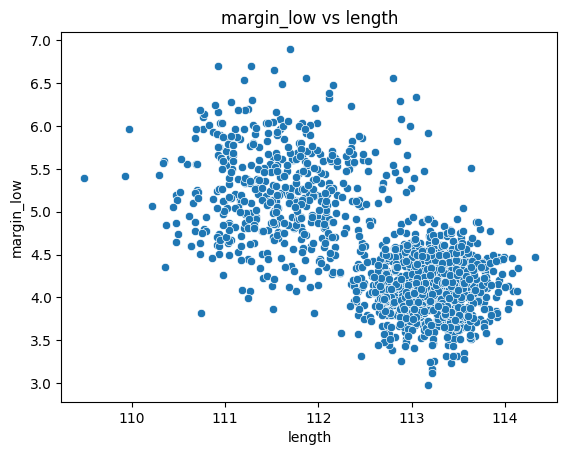

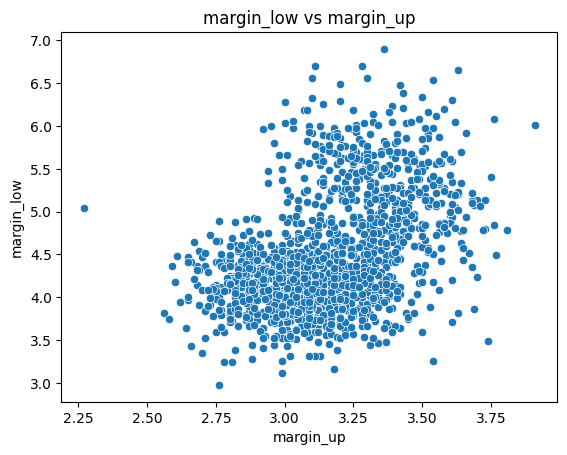

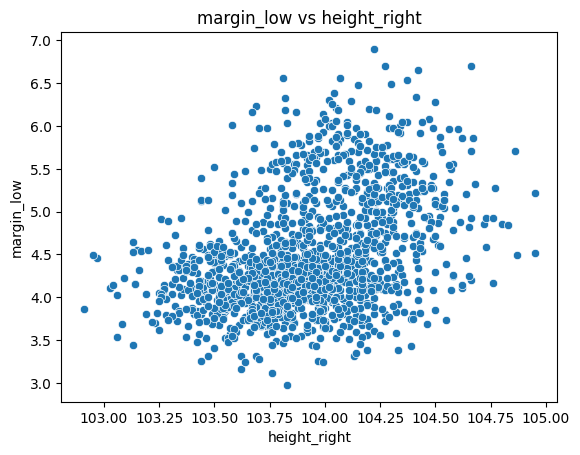

In [3]:
# Supprime les lignes sans 'margin_low' puis vérifie la linéarité avec d’autres variables.
train_data = df.dropna(subset=['margin_low'])
verifier_linearite(train_data)


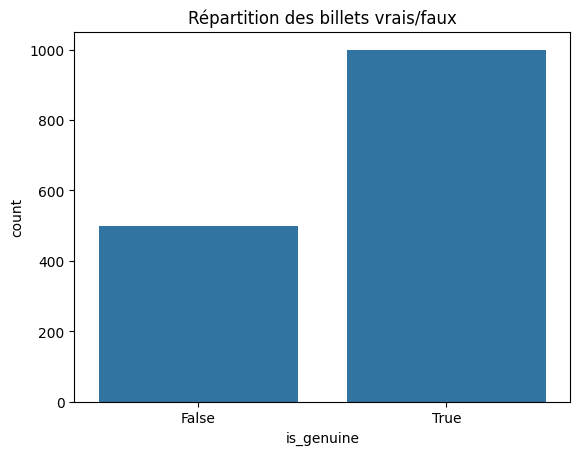

In [4]:
# Répartition vrai/faux
sns.countplot(data=df, x="is_genuine")
plt.title("Répartition des billets vrais/faux")
plt.show()

Etudes des variables

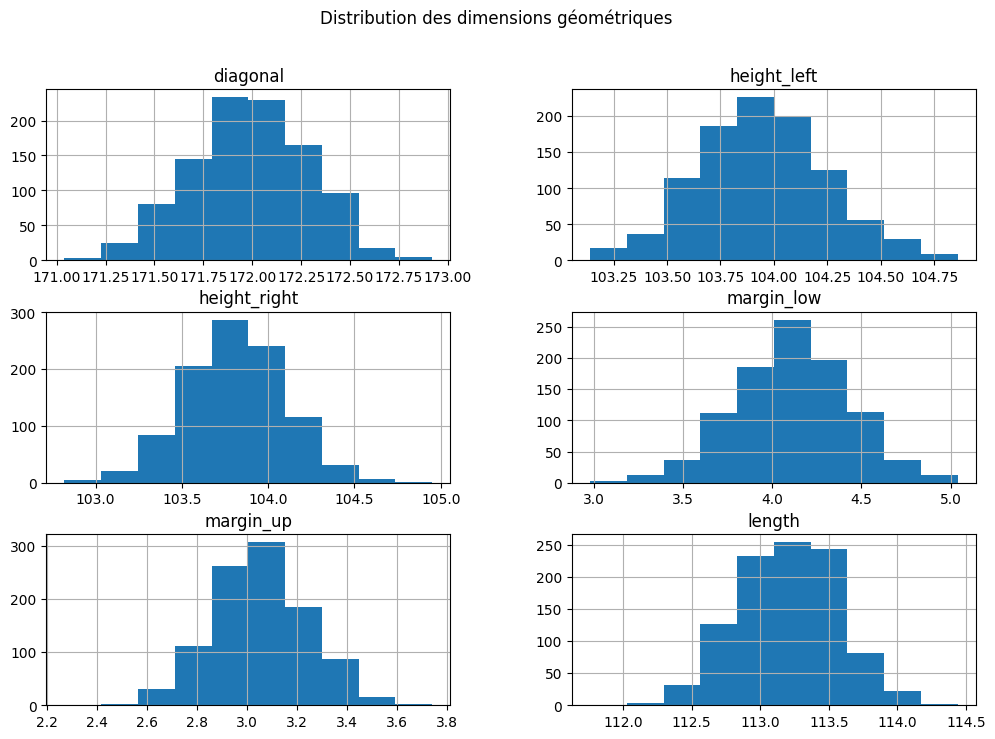

In [5]:
#Histogrammes des dimensions pour les vrais billets
df_vrai = df[df['is_genuine']== True] 
if 'kmeans_pred' in df_vrai.columns:
    df_vrai = df_vrai.drop(columns='kmeans_pred')
df_vrai.hist(figsize=(12, 8))
plt.suptitle("Distribution des dimensions géométriques")
plt.show()


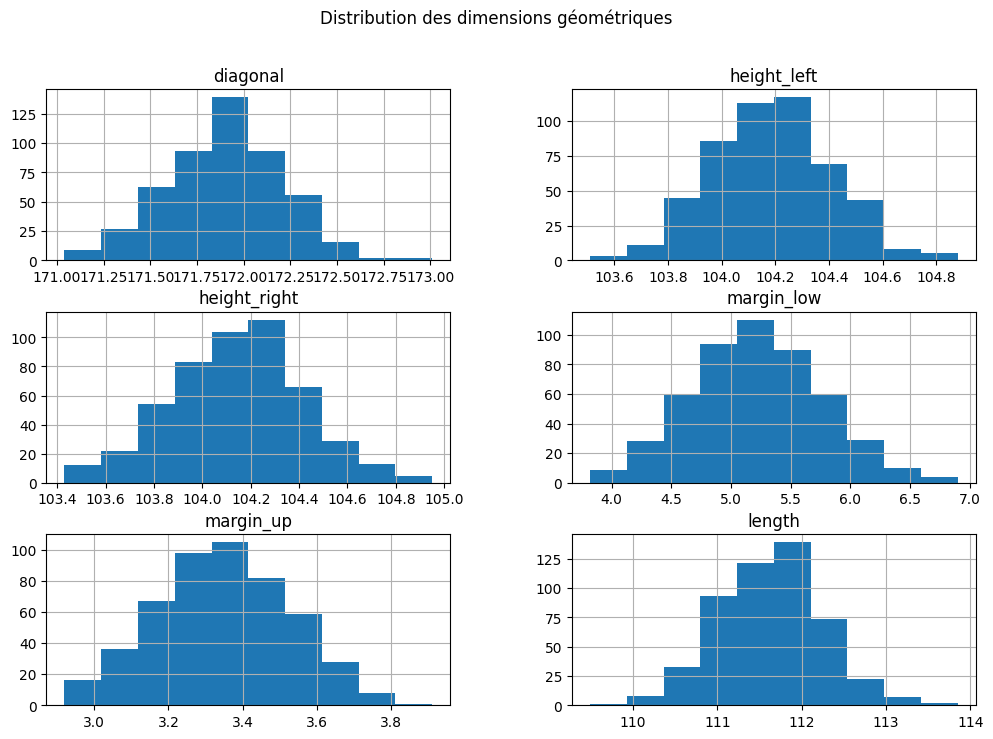

In [6]:
#Histogrammes des dimensions pour les faux billets
df_faux = df[df['is_genuine']== False] 
if 'kmeans_pred' in df_faux.columns:
    df_faux = df_faux.drop(columns='kmeans_pred')
df_faux.hist(figsize=(12, 8))
plt.suptitle("Distribution des dimensions géométriques")
plt.show()


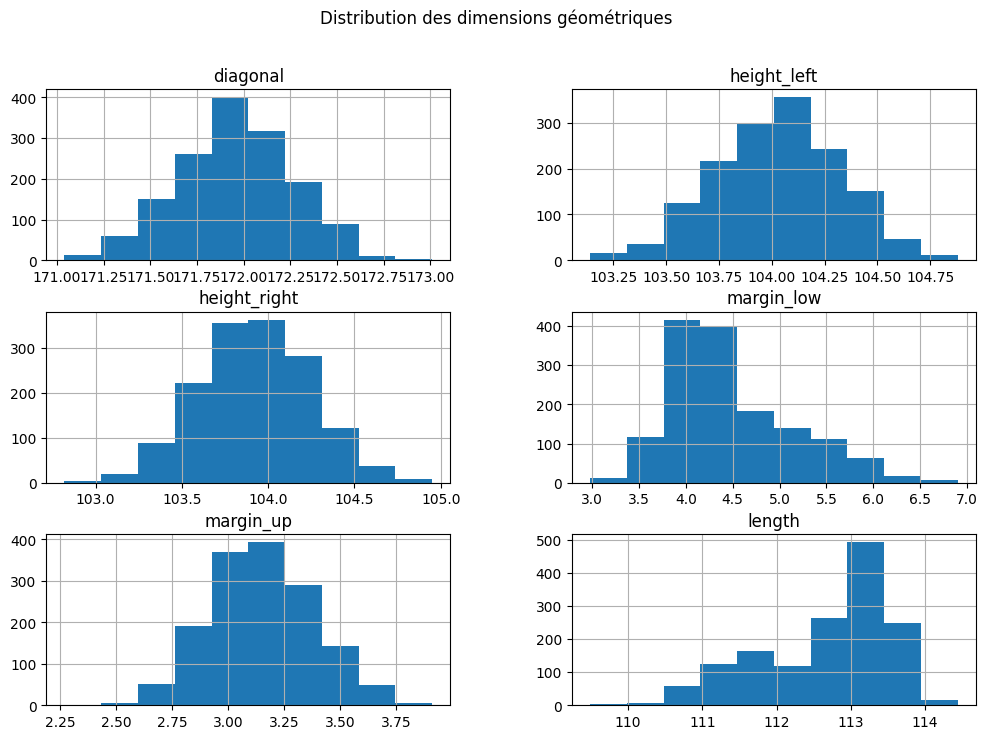

In [7]:
# Histogrammes des dimensions de TOUS les billets
df.hist(figsize=(12, 8))
plt.suptitle("Distribution des dimensions géométriques")
plt.show()


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     429.7
Date:                Fri, 17 Oct 2025   Prob (F-statistic):          5.37e-200
Time:                        19:52:55   Log-Likelihood:                -1012.8
No. Observations:                1463   AIC:                             2034.
Df Residuals:                    1459   BIC:                             2055.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.1826      5.443      4.259   

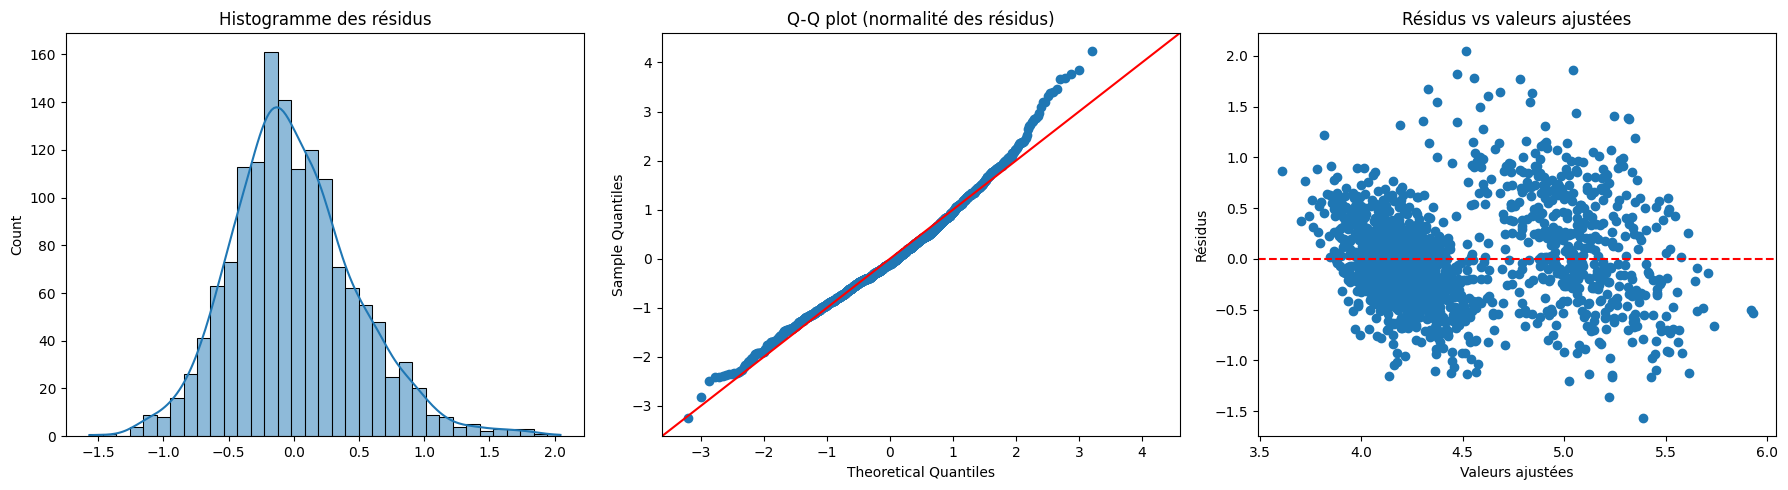

In [8]:
# Vérification Régression
verifier_hypotheses_regression(df)


##  Vérification des hypothèses de la régression linéaire

Trois graphiques ont été produits pour valider les hypothèses de la régression :

1. **Histogramme des résidus** : centré sur 0 avec une forme proche d'une courbe normale → ✔️ Normalité des résidus.
2. **Q-Q Plot** : les points suivent la droite théorique (≈ 90 % alignés) → ✔️ Confirme visuellement la normalité.
3. **Graphique résidus vs valeurs ajustées** : les résidus sont répartis aléatoirement autour de 0 sans structure apparente → ✔️ Homoscédasticité respectée.

 La présence de **deux clusters** dans le nuage de points suggère une **possible hétérogénéité** dans les observations,  
mais la variance des résidus reste constante et les hypothèses de validité sont **globalement respectées**.

Conclusion, le modèle de régression linéaire est **valide pour l'imputation** de `margin_low`.


In [9]:
# Vérification de la colinéarité avec VIF
calculer_vif(df, ['length', 'margin_up', 'height_right'])

Variance Inflation Factor (VIF) :
       variable           VIF
0        length  15071.831326
1     margin_up    256.346588
2  height_right  17312.319715


In [10]:
# Vérification des valeurs manquantes dans 'margin_low'
print("Valeurs manquantes dans 'margin_low' AVANT traitement :", df['margin_low'].isna().sum())

# Importer et appliquer la fonction d'imputation pour test
df = completer_margin_low_par_regression(df)
print("Valeurs manquantes dans 'margin_low' APRÈS traitement :", df['margin_low'].isna().sum())


Valeurs manquantes dans 'margin_low' AVANT traitement : 37
 Régression linéaire pour imputation de margin_low
R² : 0.4691
  Coefficient pour length: -0.4269
  Coefficient pour margin_up: 0.2805
  Coefficient pour height_right: 0.2745
  Intercept : 23.1826
----------------------------------------
Valeurs manquantes dans 'margin_low' APRÈS traitement : 0


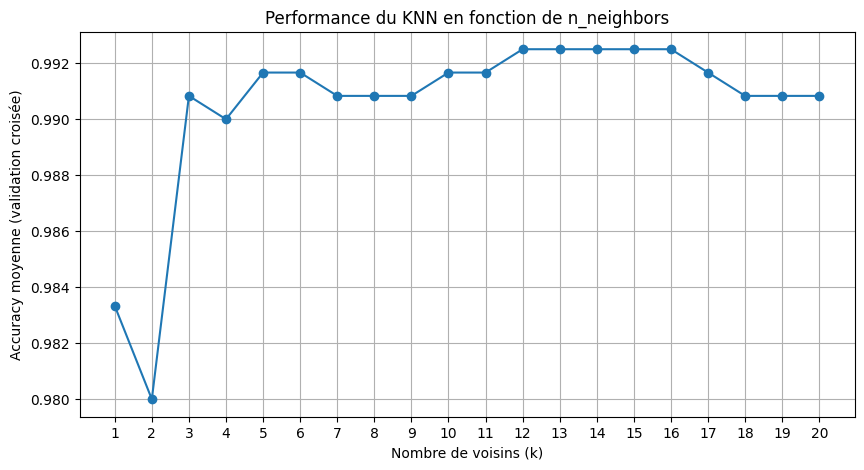

Meilleur k trouvé : 12 avec une accuracy de 0.9925
Accuracy sur le test avec KNN (k=12) : 0.9933


In [11]:
# Séparation des données
X = df.drop(columns="is_genuine")
y = df["is_genuine"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Recherche du meilleur k
best_k, all_scores = tester_k_meilleurs_voisins(X_train_scaled, y_train)

# Entraînement avec le meilleur k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# Évaluation
acc_test = knn.score(X_test_scaled, y_test)
print(f"Accuracy sur le test avec KNN (k={best_k}) : {acc_test:.4f}")

In [12]:
# Lance le traitement complet : nettoyage, entraînement, évaluation
best_model, scaler, X_train_scaled, y_train = pipeline_global(df=df)


Régression Logistique:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

KNN:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       100
           1       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.

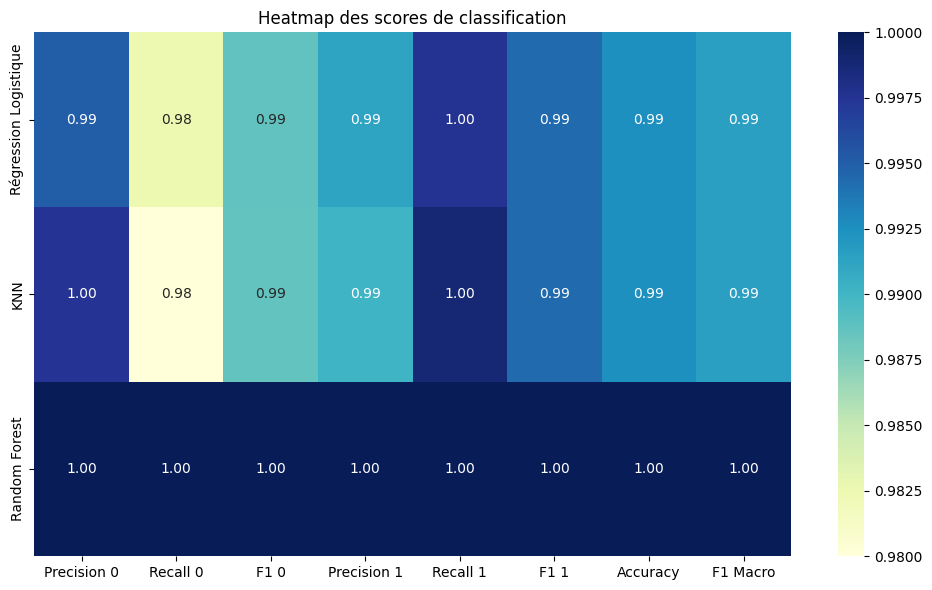

In [13]:
#  Modèles à tester
modeles = {
    "Régression Logistique": LogisticRegression(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

#  Stockage des résultats
scores_classif = {}

# 🔄Calcul des scores pour chaque modèle
for nom, modele in modeles.items():
    modele.fit(X_train_scaled, y_train)
    y_pred = modele.predict(X_train_scaled)

    # Classification report formaté en dict
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)

    # Stocker les valeurs principales (classe 0 et 1, macro avg, accuracy)
    scores_classif[nom] = {
        "Precision 0": report['0']['precision'],
        "Recall 0": report['0']['recall'],
        "F1 0": report['0']['f1-score'],
        "Precision 1": report['1']['precision'],
        "Recall 1": report['1']['recall'],
        "F1 1": report['1']['f1-score'],
        "Accuracy": report['accuracy'],
        "F1 Macro": report['macro avg']['f1-score']
    }

#  Convertir en DataFrame
df_scores = pd.DataFrame(scores_classif).T

#  Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_scores, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap des scores de classification")
plt.tight_layout()
plt.show()

Validation croisée (5 folds) - Moyennes des scores :

accuracy       : 0.9900 ± 0.0062
precision_macro: 0.9908 ± 0.0055
recall_macro   : 0.9869 ± 0.0094
f1_macro       : 0.9887 ± 0.0071
Validation croisée (5 folds) - Moyennes des scores :

accuracy       : 0.9917 ± 0.0053
precision_macro: 0.9919 ± 0.0043
recall_macro   : 0.9894 ± 0.0081
f1_macro       : 0.9906 ± 0.0060
Validation croisée (5 folds) - Moyennes des scores :

accuracy       : 0.9900 ± 0.0073
precision_macro: 0.9913 ± 0.0060
recall_macro   : 0.9863 ± 0.0106
f1_macro       : 0.9887 ± 0.0083


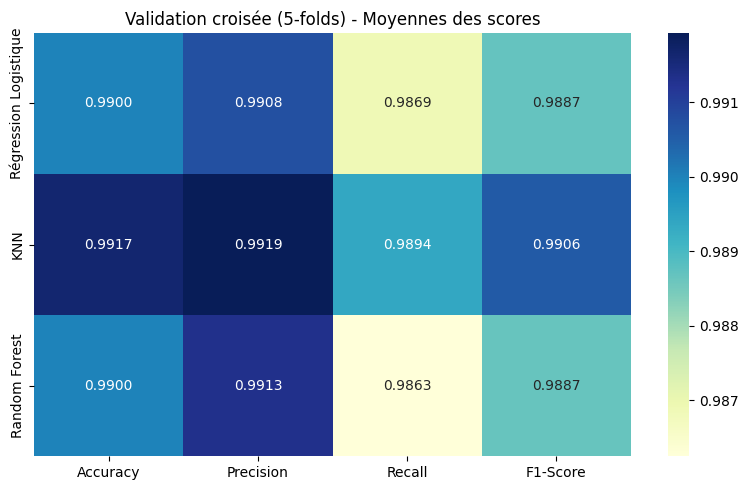

In [14]:
# Nouveau stockage des scores complets
cv_results = {}

for nom, modele in modeles.items():
    results = validation_croisee_modele(modele, X_train_scaled, y_train)
    
    # Calcul des moyennes des métriques
    cv_results[nom] = {
        "Accuracy": results["test_accuracy"].mean(),
        "Precision": results["test_precision_macro"].mean(),
        "Recall": results["test_recall_macro"].mean(),
        "F1-Score": results["test_f1_macro"].mean()
    }

# Création du DataFrame des scores
df_cv = pd.DataFrame(cv_results).T  # Transpose pour avoir les modèles en lignes

#  Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_cv, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Validation croisée (5-folds) - Moyennes des scores")
plt.tight_layout()
plt.show()


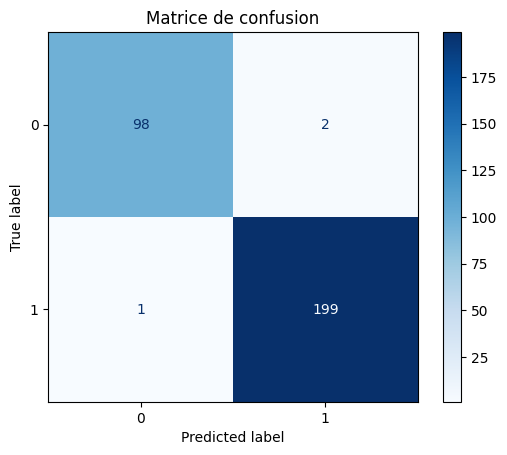

In [15]:
# Affichage de la matrice de confusion avec le modèle entraîné et le scaler sur les données actuelles
afficher_matrice_confusion(best_model, scaler, df)


## 🔍 Analyse des performances des modèles

Les résultats de la validation croisée indiquent que :

- **Régression Logistique** : modèle le plus stable et précis (≈ 98.7%)  
- **KNN** : bonnes performances mais légèrement en retrait  
- **Random Forest** : très compétitif, mais avec un écart-type plus élevé  
- **K-Means** : approche non supervisée offrant une estimation correcte (≈ 98.4%)

---

### ✅ Modèle retenu : `Régression Logistique`

Ce modèle a été retenu pour :
- Ses **excellentes performances globales** (accuracy et F1-score)
- Sa **stabilité** (faible écart-type entre les folds)
- Sa **simplicité d’interprétation** (utile pour les analystes métier)
- Sa **facilité de déploiement** dans un environnement de production



In [16]:
# Sélection aléatoire d’un index dans le DataFrame
index_aleatoire = random.randint(0, len(df) - 1)

# Extraire la ligne correspondante (sans la colonne cible)
exemple = df.drop(columns='is_genuine').iloc[index_aleatoire].to_dict()

# Prédiction avec le modèle et le scaler
resultat = predire_billet(best_model, scaler, exemple)
print("Résultat de la prédiction :", resultat)

# Afficher la vraie étiquette de ce billet
etiquette_reelle = df['is_genuine'].iloc[index_aleatoire]
print("Étiquette réelle :", "VRAI billet" if etiquette_reelle == 1 else "FAUX billet")

# Afficher l’index de la ligne sélectionnée
print("Index de la ligne :", index_aleatoire)



Résultat de la prédiction : VRAI billet
Étiquette réelle : VRAI billet
Index de la ligne : 55


## 🏁 Conclusion

Ce projet a permis de :

- Nettoyer et compléter les données grâce à une **régression linéaire multiple**
- Entraîner et comparer **4 modèles** : 3 supervisés (LogReg, KNN, Random Forest) + 1 non supervisé (K-Means)
- Évaluer les performances via **validation croisée à 5 folds**
- Sélectionner le **meilleur modèle** : `Régression Logistique`
- Créer une **application de détection automatique** des faux billets

🎯 Cette solution permet à l’ONCFM de **fiabiliser et automatiser** la détection des billets contrefaits à partir de simples mesures physiques.

